### Intuition

In general, ANNs are useful in regression and classification.
CNNs are useful for computer vision. RNNs are particularly useful for time series analysis (e.g. Stock Prediction).

The Vanishing Gradient Problem:
- Discovered by Sepp Horchreiter in 1991

- It can be shown that each weight in the neural network receives an update proportional to the partial derivative of the error function with respect to the current weight in each iteration of training.

- In some cases, the gradient will be vanishingly smal, effectively preventing the weight's value from changing. In the worst case, this may completely stop the neural network from further training.

- For example, when using activation functions like the hyperbolic tangent function - which has output in the range (0, 1) - backpropagation computes gradients via the chain rule thereby leading to a gradient error that decays exponentially with the size of the network, thereby leading to relatively slow training.

LSTM - Long short-term memory:
Unlike traditional feedforward neural networks, LSTM networks have feedback connections that help "remember" values over arbitrary time intervals.


### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing training set

In [6]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
training_set = dataset_train.iloc[:, 1:2].values
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### Feature scaling

In [7]:
# Perform normalisation
# x = (x - min(x)) / range(x) 
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Creating new data structure with 60 timesteps and 1 output

In [10]:
# at each day t, we want our RNN to consider the 60 preceding days
# when predicting the stock price at day t + 1
# the time step is a hyperparameter in our case
# if the timestep is too low, then there is insufficience info
# if the timestep is too high, there will likely be overfitting

X_train = []
y_train = []
set_size = training_set_scaled.size
time_step = 60

for i in range(time_step, set_size):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
print(X_train, y_train)

[[0.08581368 0.09701243 0.09433366 ... 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 ... 0.08034452 0.08497656 0.08627874]
 [0.09433366 0.09156187 0.07984225 ... 0.08497656 0.08627874 0.08471612]
 ...
 [0.92106928 0.92438053 0.93048218 ... 0.95475854 0.95204256 0.95163331]
 [0.92438053 0.93048218 0.9299055  ... 0.95204256 0.95163331 0.95725128]
 [0.93048218 0.9299055  0.93113327 ... 0.95163331 0.95725128 0.93796041]] [0.08627874 0.08471612 0.07454052 ... 0.95725128 0.93796041 0.93688146]


### Reshaping our data structure

In [16]:
n_rows = X_train.shape[0] 
n_cols = X_train.shape[1]

In [17]:
X_train = np.reshape(X_train, (n_rows, n_cols, 1))

### Importing Keras libraries

In [4]:
from keras.models import Sequential
from keras.layers import (LSTM, Dropout, Dense)

### Building the RNN

In [18]:
rnn_model = Sequential() #initialization
# add 1st LSTM layer with 50 cells/memory units
# since we are building a stacked RNN, we need to return the full output sequence
rnn_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2)) # standard 20% neuron dropout to avoid overfitting
# add 2nd LSTM layer with 50 cells/memory units
rnn_model.add(LSTM(units = 50, return_sequences = True))
rnn_model.add(Dropout(0.2))
# add 3rd LSTM layer
rnn_model.add(LSTM(units = 50, return_sequences = True))
rnn_model.add(Dropout(0.2))
# add 4th LSTM layer, no need to return sequences (default = false)
rnn_model.add(LSTM(units = 50))
rnn_model.add(Dropout(0.2))
# add output layer
rnn_model.add(Dense(units = 1))
# Compile RNN with loss function = mean squared loss
rnn_model.compile(optimizer = 'adam', 
                  loss = 'mean_squared_error')

### Fit RNN to the training set

In [19]:
rnn_model.fit(x = X_train,
             y = y_train,
             epochs = 100, 
              batch_size = 32)

Epoch 1/100
38/38 [==============================] - 8s 219ms/step - loss: 0.0326
Epoch 2/100
38/38 [==============================] - 9s 231ms/step - loss: 0.0060
Epoch 3/100
38/38 [==============================] - 9s 239ms/step - loss: 0.0054
Epoch 4/100
38/38 [==============================] - 8s 208ms/step - loss: 0.0055
Epoch 5/100
38/38 [==============================] - 8s 209ms/step - loss: 0.0061
Epoch 6/100
38/38 [==============================] - 8s 207ms/step - loss: 0.0052
Epoch 7/100
38/38 [==============================] - 8s 214ms/step - loss: 0.0043
Epoch 8/100
38/38 [==============================] - 9s 229ms/step - loss: 0.0044
Epoch 9/100
38/38 [==============================] - 9s 226ms/step - loss: 0.0050
Epoch 10/100
38/38 [==============================] - 8s 200ms/step - loss: 0.0044
Epoch 11/100
38/38 [==============================] - 8s 213ms/step - loss: 0.0051
Epoch 12/100
38/38 [==============================] - 8s 215ms/step - loss: 0.0051
Epoch 13/100


38/38 [==============================] - 7s 195ms/step - loss: 0.0013
Epoch 100/100
38/38 [==============================] - 9s 231ms/step - loss: 0.0014


### Obtaining Google's real stock price in 2017

In [21]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

### Predicting Google's stock  price for each financial day of 2017

In [22]:
# we need data from test set AND data from the training set
# because we need 60 previous days
# some of thse days will be in December 2016 and others
# in January 2017 onwards
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

# for each financial day, we need the stock prices of the 60
# previous financial days
# we will need our min index = 60 financial days before Jan. 3rd
# our max index = 60 financial days before Jan 31st.
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# we need our inputs to be formatted as a single column
inputs = inputs.reshape(-1,1)
# normalise our inputs to feed them to our RNN
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


predicted_stock_price = rnn_model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

### Visualizing results

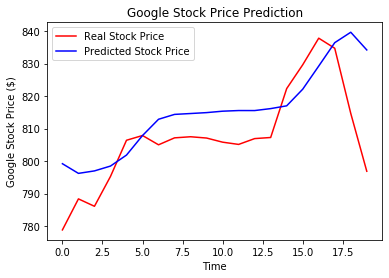

In [23]:
plt.plot(real_stock_price, 
        color = "red",
        label = "Real Stock Price")
plt.plot(predicted_stock_price, 
        color = "blue",
        label = "Predicted Stock Price")
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price ($)')
plt.legend()
plt.show()


### Model Diagnostics

In [31]:
# Computing RMSE of our model predictions
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

Possible improvements to our model:
- More training data

- Increasing the number of timesteps 